In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing  import FunctionTransformer
np.set_printoptions(precision = 3, suppress = True)
import warnings
warnings.filterwarnings("ignore")

## **Healthy Dog Vet Info Preprocessing:**

### DESCRIPTION: *[LINK HERE](https://frontiersin.figshare.com/articles/dataset/Data_Sheet_1_Effect_of_Age_Breed_and_Sex_on_the_Health-Related_Quality_of_Life_of_Owner_Assessed_Healthy_Dogs_xlsx/13718905?file=26357467)*  
**Using an app, this exploratory study generated information on HRQL in a large cohort of dogs deemed healthy according to the owner. It forms the basis for further studies investigating the natural history of HRQL of dogs to inform the interpretation of interventional studies, but highlights the risks of relying on owner impression of health status.  A previously published health-related quality of life (HRQL) instrument (VetMetrica™) that generates scores in four domains of quality of life in dogs - Energetic and Enthusiastic (E/E), Happy and Content (H/C), Active and Comfortable (A/C), and Calm and Relaxed (C/R), generated information on HRQL in 4,217 dogs (3 months−21 years). Dogs were categorized by age; young, 3–47 months, middle-aged, 48–95 months, and old, 96 months and older. Owners considered 2,959 dogs (3–95 months) to be “in perfect health” and these were used to explore the relationship between age, sex, breed and HRQL in apparently healthy dogs.**

In [22]:
dogs = pd.read_excel('Healthy_Dog_Vet_Reports.xlsx')

X = dogs.loc[:,["Age (months)", "Age segment", "Energetic/Enthusiastic", "Happy/Content", "Active/Comfortable", "Calm/Relaxed"]]
y = dogs['BreedGroupName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Pipeline:

In [23]:
numeric_feats = ["Energetic/Enthusiastic", "Happy/Content", "Active/Comfortable", "Calm/Relaxed"]
scaling = Pipeline(
    steps = [("imputer", SimpleImputer(strategy = "median")), ("scaler", StandardScaler())]
)

cat_feats = ["Age segment"]
categorize = Pipeline(
    steps = [
        ("encoder", OneHotEncoder(handle_unknown = "ignore")), 
        ("selector", SelectKBest(chi2, k = 20))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("num", scaling, numeric_feats), 
        ("cat", categorize, cat_feats)
    ]
)

clf = Pipeline(
    steps = [("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter = 500, multi_class = 'multinomial', solver = 'lbfgs'))]
)

In [24]:
clf.fit(X_train, y_train)

print("model score: %.3f" % clf.score(X_test, y_test))
clf

model score: 0.365


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Energetic/Enthusiastic',
                                                   'Happy/Content',
                                                   'Active/Comfortable',
                                                   'Calm/Relaxed']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectKBest(k=20,
                                                                               score_func=<function chi2 at 0x000001A5EC2EE020>))]),
                                                  ['Age segment'])])),
                ('classifier',
                 LogisticRegression(max_iter=500, multi_class='multinomial'))])

### Export:

In [25]:
dogs_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
dogs_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

dogs_train.to_csv("dogs_train.csv", index = False)
dogs_test.to_csv("dogs_test.csv", index = False)

### Regularization:

In [26]:
n_samples = 40
Lambda = 0.001

X = np.random.rand(n_samples)
y = np.cos(1.5 * np.pi * X) + 0.5 * np.random.rand(n_samples)
X = X.reshape(-1, 1)

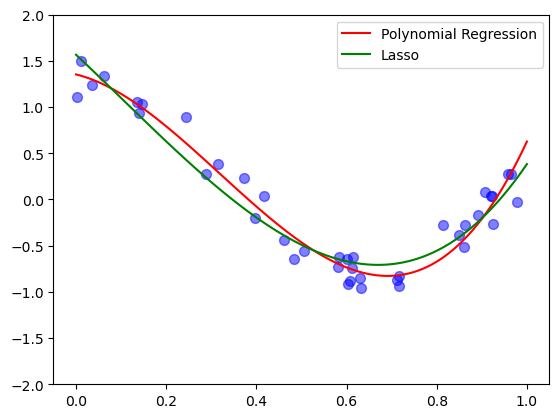

In [27]:
polymodel = PolynomialFeatures(degree = 3, include_bias = True) # Regular cubic poly regression
data = polymodel.fit_transform(X)
model1 = LinearRegression()
model2 = Lasso(alpha = Lambda)


model1.fit(data,y) 
model2.fit(data,y) 


X_plot = np.linspace(0, 1, 100).reshape(-1, 1)
X_plot_poly = polymodel.transform(X_plot)
fig = plt.figure()
plt.scatter(X, y, c = 'b', s = 50, alpha = .5)
plt.plot(X_plot, model1.predict(X_plot_poly), '-r', label = 'Polynomial Regression')
plt.plot(X_plot, model2.predict(X_plot_poly), '-g', label = 'Lasso')
plt.legend()
plt.ylim(-2, 2)
fig.show()

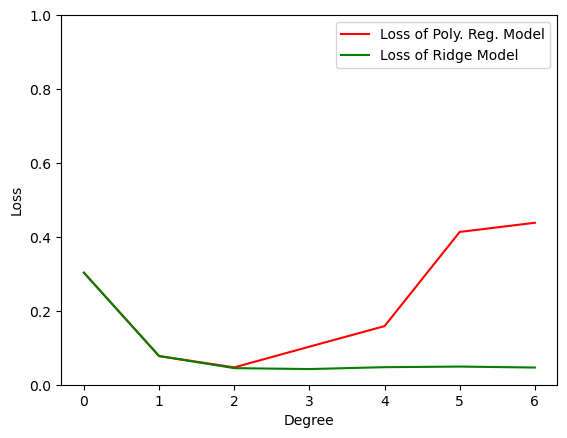

In [28]:
Loss1, Loss2 = [],[]

for deg in range(1,8):
    polymodel = PolynomialFeatures(degree = deg, include_bias = True)
    data = polymodel.fit_transform(X)
    model1 = LinearRegression()
    model2 = Ridge(alpha = Lambda)
    
    
    model1.fit(data,y) 
    model2.fit(data,y) 
  
    y_pred1 = model1.predict(polymodel.transform(X))
    y_pred2 = model2.predict(polymodel.transform(X))
    
    Loss1.append(((y_pred1 - y)**2).mean() +  Lambda*(np.abs(model1.coef_)).sum())
    Loss2.append(((y_pred2 - y)**2).mean() +  Lambda*(np.abs(model2.coef_)).sum())

fig = plt.figure()
xv = np.arange(0,deg)
plt.plot(xv, Loss1,'-r', label = 'Loss of Poly. Reg. Model')
plt.plot(xv, Loss2,'-g', label = 'Loss of Ridge Model')
plt.ylim(0, 1)
plt.ylabel("Loss")
plt.xlabel('Degree')
plt.legend()
plt.show()

## **Average Monthly Precipitation in Germany Preprocessing:**

### DESCRIPTION: *[LINK HERE](https://opendata.dwd.de/climate_environment/CDC/Readme_intro_CDC_ftp.pdf)*  
Precipitation data from a dedicated precipitation observation network (with about 2000 active stations) and partner stations on equal terms are available at 1-minute, 10-minute, hourly, daily and monthly resolution. These monthly, seasonal and annual averages (of air temperature, precipitation and sunshine duration) are derived from the gridded fields covering Germany. Regional averages of climatological indices are available as annual averages for the following parameters: 
* Days with precipitation ≥ 10 mm
* Days with precipitation ≥ 20 mm
* Hot days (days with maximum temperature ≥ 30°C)
* Summer days (days with minimum temperature ≥ 25°C)
* Frost days (days with minimum temperature < 0°C)
* Ice days (days with maximum temperature < 0°C)

In [29]:
rain = pd.read_excel('CDC_DWD_Regional_Monthly_Precip_Avg.xlsx')
rain["Date"] = pd.to_datetime(dict(year = rain["Year"], month = rain["Month"], day = 1)) # Converting 2 cols to 1 datetime col

y = rain['Germany']
lags = 12
X = pd.concat({f"lag_{i}": y.shift(i) for i in range(1, lags + 1)}, axis = 1) # Allign data into monthly
X = X.dropna()
y = y.loc[X.index] # Reallign with y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Pipeline:

In [30]:
numeric_feature = X_train.columns.tolist()
numeric_transformer = Pipeline(
    steps = [("imputer", SimpleImputer(strategy = "median")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("num", numeric_transformer, numeric_feature)
]
)

clfR = Pipeline(
    steps = [("preprocessor", preprocessor), ("classifier", LinearRegression())]
)

In [31]:
clfR.fit(X_train, y_train)

print("model score: %.3f" % clfR.score(X_test, y_test))
clfR

model score: 0.045


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11',
                                                   'lag_12'])])),
                ('classifier', LinearRegression())])

### Export:

In [32]:
rain_train = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
rain_test = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

rain_train.to_csv("rain_train.csv", index = False)
rain_test.to_csv("rain_test.csv", index = False)

### Regularization:

In [33]:
n_samples = 40
Lambda = 0.001

X = np.random.rand(n_samples)
y = np.cos(1.5 * np.pi * X) + 0.5 * np.random.rand(n_samples)
X = X.reshape(-1, 1)

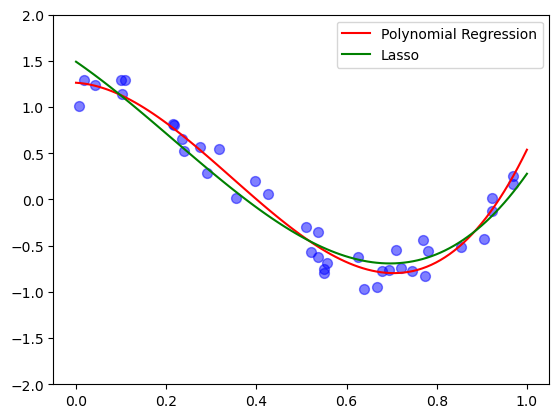

In [34]:
polymodel = PolynomialFeatures(degree = 3, include_bias = True) # Regular cubic poly regression
data = polymodel.fit_transform(X)
model1 = LinearRegression()
model2 = Lasso(alpha = Lambda)


model1.fit(data,y) 
model2.fit(data,y) 


X_plot = np.linspace(0, 1, 100).reshape(-1, 1)
X_plot_poly = polymodel.transform(X_plot)
fig = plt.figure()
plt.scatter(X, y, c = 'b', s = 50, alpha = .5)
plt.plot(X_plot, model1.predict(X_plot_poly), '-r', label = 'Polynomial Regression')
plt.plot(X_plot, model2.predict(X_plot_poly), '-g', label = 'Lasso')
plt.legend()
plt.ylim(-2, 2)
fig.show()

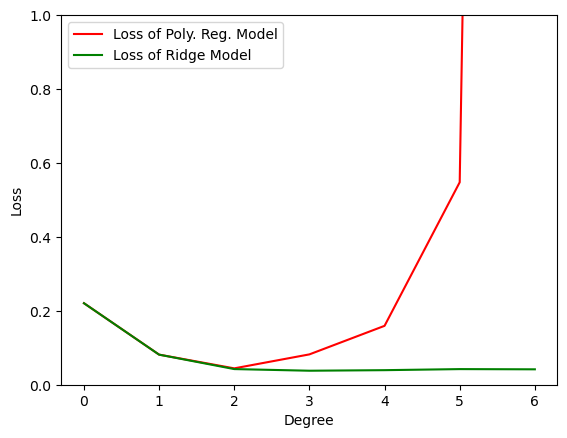

In [35]:
Loss1, Loss2 = [],[]

for deg in range(1,8):
    polymodel = PolynomialFeatures(degree = deg, include_bias = True)
    data = polymodel.fit_transform(X)
    model1 = LinearRegression()
    model2 = Ridge(alpha = Lambda)
    
    
    model1.fit(data,y) 
    model2.fit(data,y) 
  
    y_pred1 = model1.predict(polymodel.transform(X))
    y_pred2 = model2.predict(polymodel.transform(X))
    
    Loss1.append(((y_pred1 - y)**2).mean() +  Lambda*(np.abs(model1.coef_)).sum())
    Loss2.append(((y_pred2 - y)**2).mean() +  Lambda*(np.abs(model2.coef_)).sum())

fig = plt.figure()
xv = np.arange(0,deg)
plt.plot(xv, Loss1,'-r', label = 'Loss of Poly. Reg. Model')
plt.plot(xv, Loss2,'-g', label = 'Loss of Ridge Model')
plt.ylim(0, 1)
plt.ylabel("Loss")
plt.xlabel('Degree')
plt.legend()
plt.show()